In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from User_Classes import UserClass
from Advertising_Environment import calculate_margin, calculate_price_index
from Clairvoyant import find_optimal_bid_for_class
from Advertising.GPTS_Learner import GPTS_Learner

import warnings
warnings.filterwarnings("ignore")

# Environment

In [56]:
#Environment
n_arms = 100
min_bid = 0.01
max_bid = 3.0
bids = np.linspace(min_bid, max_bid, n_arms)
sigma = 200

user = UserClass(name='C1')

#names = ['Young ', 'Old', 'Not Sporty', 'Sporty']

price = 200
T = 150
n_experiments = 5

gpts_rewards_per_experiment = []

optimum_bid = find_optimal_bid_for_class(user.user_index, calculate_price_index(price))

In [57]:
def fun(user_class, bid, price):
    mean_per_bid = user_class.get_click_bids(bid) * (user_class.get_conversion_per_price(price) * calculate_margin(price)) - user_class.get_click_bids(bid) * user_class.get_cost_per_click(bid)    #sample_cost
    return mean_per_bid

In [58]:
class BiddingEnvironment:
    def __init__(self, bids, sigma, user_class, price, n_arms):
        self.bids = bids
        self.means = self.initialize_means(user_class=user_class, bids=bids, price=price)
        self.sigmas = np.ones(len(bids)) * sigma
        self.price = price
        self.n_arms = n_arms

    def initialize_means(self, user_class, bids, price):
        means = np.zeros(len(bids))
        for i in range(len(means)):
                means[i] = fun(user_class, bids[i], price)
        return means

    def round(self, pulled_arm):
        #print('Means')
        #print(self.means[pulled_arm])
        #print('Means Array')
        #print(self.means)
        return np.random.normal(self.means[pulled_arm], self.sigmas[pulled_arm])

# Experiment

In [59]:
for e in tqdm(range(0, 5)):
    env = BiddingEnvironment(bids=bids, sigma = sigma, user_class=user, price=price, n_arms=n_arms)
    gpts_learner = GPTS_Learner(n_arms, arms=bids)

    for t in range(T):
        #GP Thompson Sampling
        pulled_arm = gpts_learner.pull_arm()
        reward = env.round(pulled_arm)
        gpts_learner.update(pulled_arm, reward)

    gpts_rewards_per_experiment.append(gpts_learner.collected_rewards)

100%|██████████| 5/5 [00:25<00:00,  5.02s/it]


# Cumulative Regret
The cumulative regret at a given round (in our case day) t is the sum of the regrets experienced up until and including that day.

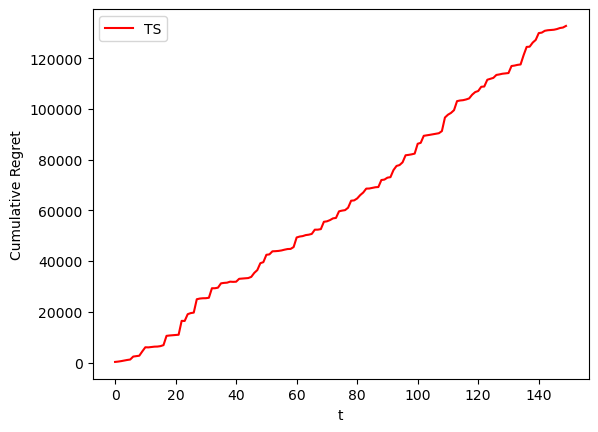

In [63]:
plt.figure(0)
plt.ylabel("Cumulative Regret")
plt.xlabel("t")
plt.plot(np.cumsum(np.mean(optimum_bid[1] - gpts_rewards_per_experiment, axis=0)), 'r')
plt.legend(["TS"])
plt.show()

# Cumulative Reward

The cumulative reward at a given round (in our case day) t is the sum of the rewards received up until and including that day.

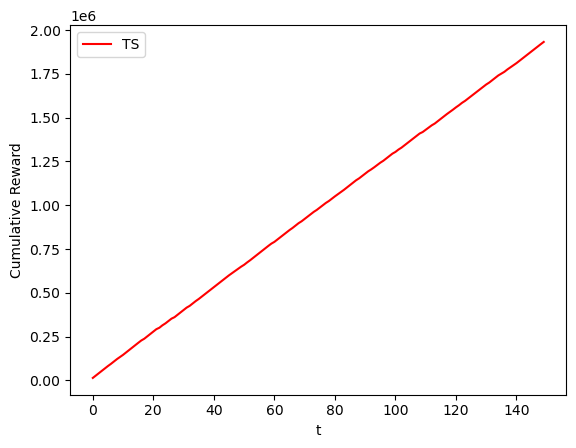

In [64]:
plt.figure(0)
plt.ylabel("Cumulative Reward")
plt.xlabel("t")
plt.plot(np.cumsum(np.mean(gpts_rewards_per_experiment, axis=0)), 'r')
plt.legend(["TS"])
plt.show()

# Istantaneous Regret
Instantaneous regret is a measure of how much better you could have done on a particular day t if you had made the optimal decisions (as determined by your clairvoyant optimization algorithm). It's defined as the difference between the optimal reward and the actual reward received on day t.



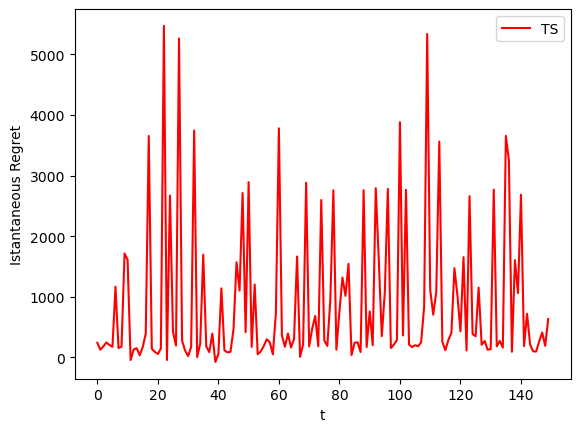

In [65]:
plt.figure(0)
plt.ylabel("Istantaneous Regret")
plt.xlabel("t")
plt.plot(np.mean(optimum_bid[1] - gpts_rewards_per_experiment, axis=0), 'r')
plt.legend(["TS"])
plt.show()

# Istantaneous Reward
The instantaneous reward at a given round (or day) t would be the reward received on that particular day.

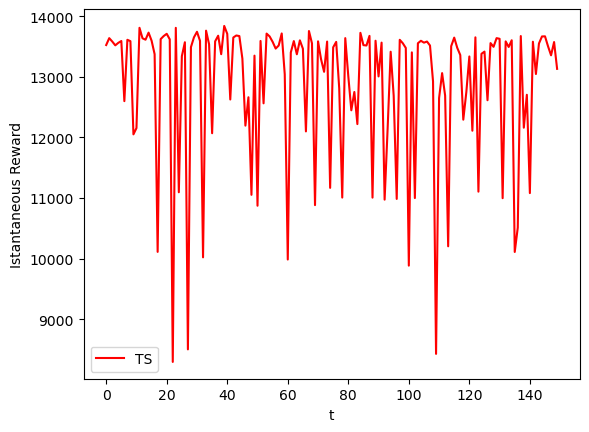

In [66]:
plt.figure(0)
plt.ylabel("Istantaneous Reward")
plt.xlabel("t")
plt.plot(np.mean(gpts_rewards_per_experiment, axis=0), 'r')
plt.legend(["TS"])
plt.show()